In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd

sentiment_df = pd.read_csv(
    "/content/drive/MyDrive/Colab_datasets/fear_greed_index.csv"
)

trades_df = pd.read_csv(
    "/content/drive/MyDrive/Colab_datasets/historical_data.csv"
)


In [6]:
sentiment_df.head()
trades_df.shape


(211224, 16)

In [7]:
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [8]:
trades_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [9]:
sentiment_df.info()
trades_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [13]:
trades_df['Date'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
).dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

In [14]:
merged_df = pd.merge(
    trades_df,
    sentiment_df[['date', 'classification', 'value']],
    left_on='Date',
    right_on='date',
    how='left'
)


In [15]:
merged_df.shape
merged_df['classification'].isna().mean()


np.float64(2.840586297011703e-05)

In [16]:
merged_df['Closed PnL'] = merged_df['Closed PnL'].fillna(0)
merged_df['Side'] = merged_df['Side'].str.lower()
merged_df['Size USD'] = merged_df['Size USD'].abs()


In [17]:
merged_df['is_win'] = merged_df['Closed PnL'] > 0
merged_df['is_loss'] = merged_df['Closed PnL'] < 0
merged_df['is_buy'] = merged_df['Side'] == 'buy'
merged_df['is_sell'] = merged_df['Side'] == 'sell'


In [18]:
daily_perf = merged_df.groupby(
    ['Account', 'Date', 'classification']
).agg(
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('is_win', 'mean'),
    trade_count=('Account', 'count'),
    total_volume_usd=('Size USD', 'sum')
).reset_index()


In [19]:
daily_perf.head()
daily_perf.describe()


,total_pnl,win_rate,trade_count,total_volume_usd
count,2340.000000,2340.000000,2340.000000,2.340000e+03
mean,4382.259380,0.359653,90.264103,5.090166e+05
std,28411.103383,0.343419,214.650554,2.414245e+06
min,-358963.139984,0.000000,1.000000,0.000000e+00
25%,0.000000,0.000000,9.000000,1.575387e+04
50%,206.352695,0.318182,29.000000,6.916826e+04
75%,1842.763729,0.607357,80.000000,2.508897e+05
max,533974.662903,1.000000,4083.000000,5.125045e+07


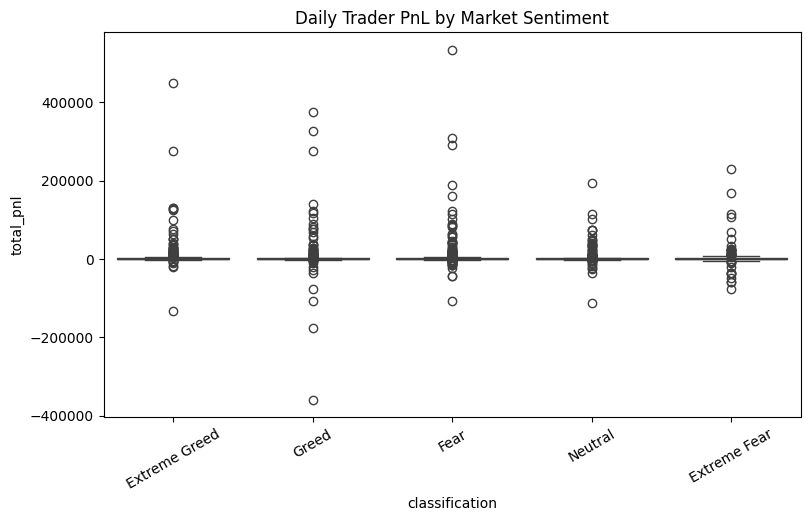

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
sns.boxplot(
    data=daily_perf,
    x='classification',
    y='total_pnl'
)
plt.title("Daily Trader PnL by Market Sentiment")
plt.xticks(rotation=30)
plt.show()


In [21]:
merged_df['trader_type'] = pd.qcut(
    merged_df['Size USD'],
    q=[0, 0.7, 0.9, 1.0],
    labels=['Retail', 'Mid', 'Whale']
)


/tmp/ipython-input-600629233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_perf = merged_df.groupby(


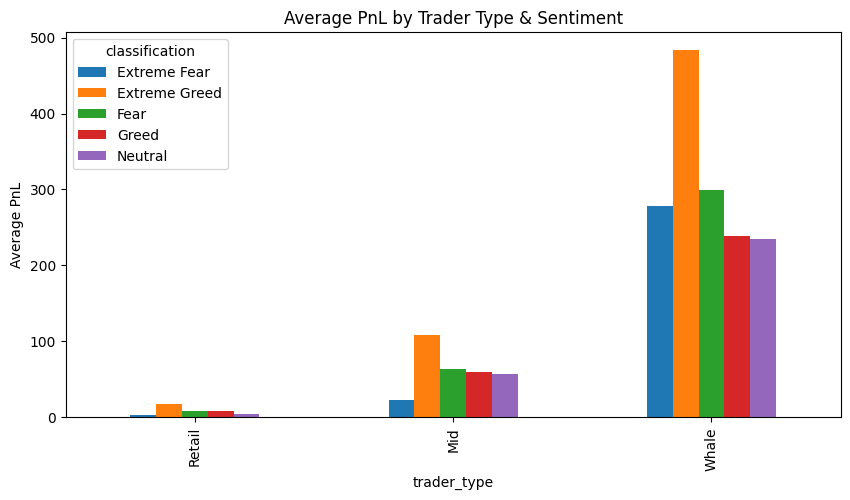

In [22]:
segment_perf = merged_df.groupby(
    ['trader_type', 'classification']
)['Closed PnL'].mean().unstack()

segment_perf.plot(kind='bar', figsize=(10,5))
plt.title("Average PnL by Trader Type & Sentiment")
plt.ylabel("Average PnL")
plt.show()


In [23]:
panic_sell = merged_df[
    (merged_df['classification'].isin(['Fear','Extreme Fear'])) &
    (merged_df['is_sell'])
]['Closed PnL'].mean()

panic_sell


np.float64(42.542558274005515)

In [24]:
fomo_buy = merged_df[
    (merged_df['classification'].isin(['Greed','Extreme Greed'])) &
    (merged_df['is_buy'])
]['Closed PnL'].mean()

fomo_buy


np.float64(18.882475745201805)

In [25]:
contrarian = daily_perf[
    ((daily_perf['classification'].isin(['Fear','Extreme Fear'])) & (daily_perf['total_pnl'] > 0)) |
    ((daily_perf['classification'].isin(['Greed','Extreme Greed'])) & (daily_perf['total_pnl'] > 0))
]

top_contrarians = (
    contrarian.groupby('Account')['total_pnl']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_contrarians


,total_pnl
Account,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.803689e+06
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,1.765213e+06
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,9.472744e+05
0xbaaaf6571ab7d571043ff1e313a9609a10637864,8.827951e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,5.835861e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1,5.333457e+05
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,5.036268e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd,4.937253e+05
0x4f93fead39b70a1824f981a54d4e55b278e9f760,4.209331e+05
